In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers

In [22]:
tf.__version__

'2.17.0'

In [24]:
import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'gs://cloud-training/mlongcp/v3.0_MLonGC/toy_data/petfinder-mini_toy.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
# TODO
# read a comma-separated values (csv) file into DataFrame
dataframe = pd.read_csv(csv_file)

In [25]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [26]:
# In the original dataset, `'AdoptionSpeed'` of `4` indicates
# a pet was not adopted.
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# Drop unused features.
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])

In [27]:
train, val, test = np.split(dataframe.sample(frac=1), [int(0.8*len(dataframe)), int(0.9*len(dataframe))])

In [28]:
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

3999 training examples
500 validation examples
500 test examples


In [29]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.to_numpy()[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [30]:
batch_size = 5
train_ds = df_to_dataset(train, batch_size=batch_size)

In [31]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['Age'])
print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt', 'target']
A batch of ages: tf.Tensor(
[[2]
 [2]
 [1]
 [1]
 [4]], shape=(5, 1), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)


In [32]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [33]:
photo_count_col = train_features['PhotoAmt']
layer = get_normalization_layer('PhotoAmt', train_ds)
layer(photo_count_col)

2024-12-11 16:18:29.224872: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.8298419],
       [-0.5098906],
       [-0.8298419],
       [ 0.7699147],
       [-0.8298419]], dtype=float32)>

In [34]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [35]:
test_type_col = train_features['Type']
test_type_layer = get_category_encoding_layer(name='Type',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)>

In [36]:
test_age_col = train_features['Age']
test_age_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
test_age_layer(test_age_col)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)>

In [37]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [38]:
all_inputs = {}
encoded_features = []

# Numerical features.
for header in ['PhotoAmt', 'Fee']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs[header] = numeric_col
  encoded_features.append(encoded_numeric_col)

2024-12-11 16:19:11.919916: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [39]:
age_col = tf.keras.Input(shape=(1,), name='Age', dtype='int64')

encoding_layer = get_category_encoding_layer(name='Age',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=5)
encoded_age_col = encoding_layer(age_col)
all_inputs['Age'] = age_col
encoded_features.append(encoded_age_col)

In [40]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']

for header in categorical_cols:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs[header] = categorical_col
  encoded_features.append(encoded_categorical_col)

2024-12-11 16:19:27.489681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [41]:
encoded_features

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_1>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_3>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_5>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, name=keras_tensor_9>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, name=keras_tensor_11>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_13>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_15>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_17>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, name=keras_tensor_21>,
 <KerasTenso

In [42]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"],
              run_eagerly=True)

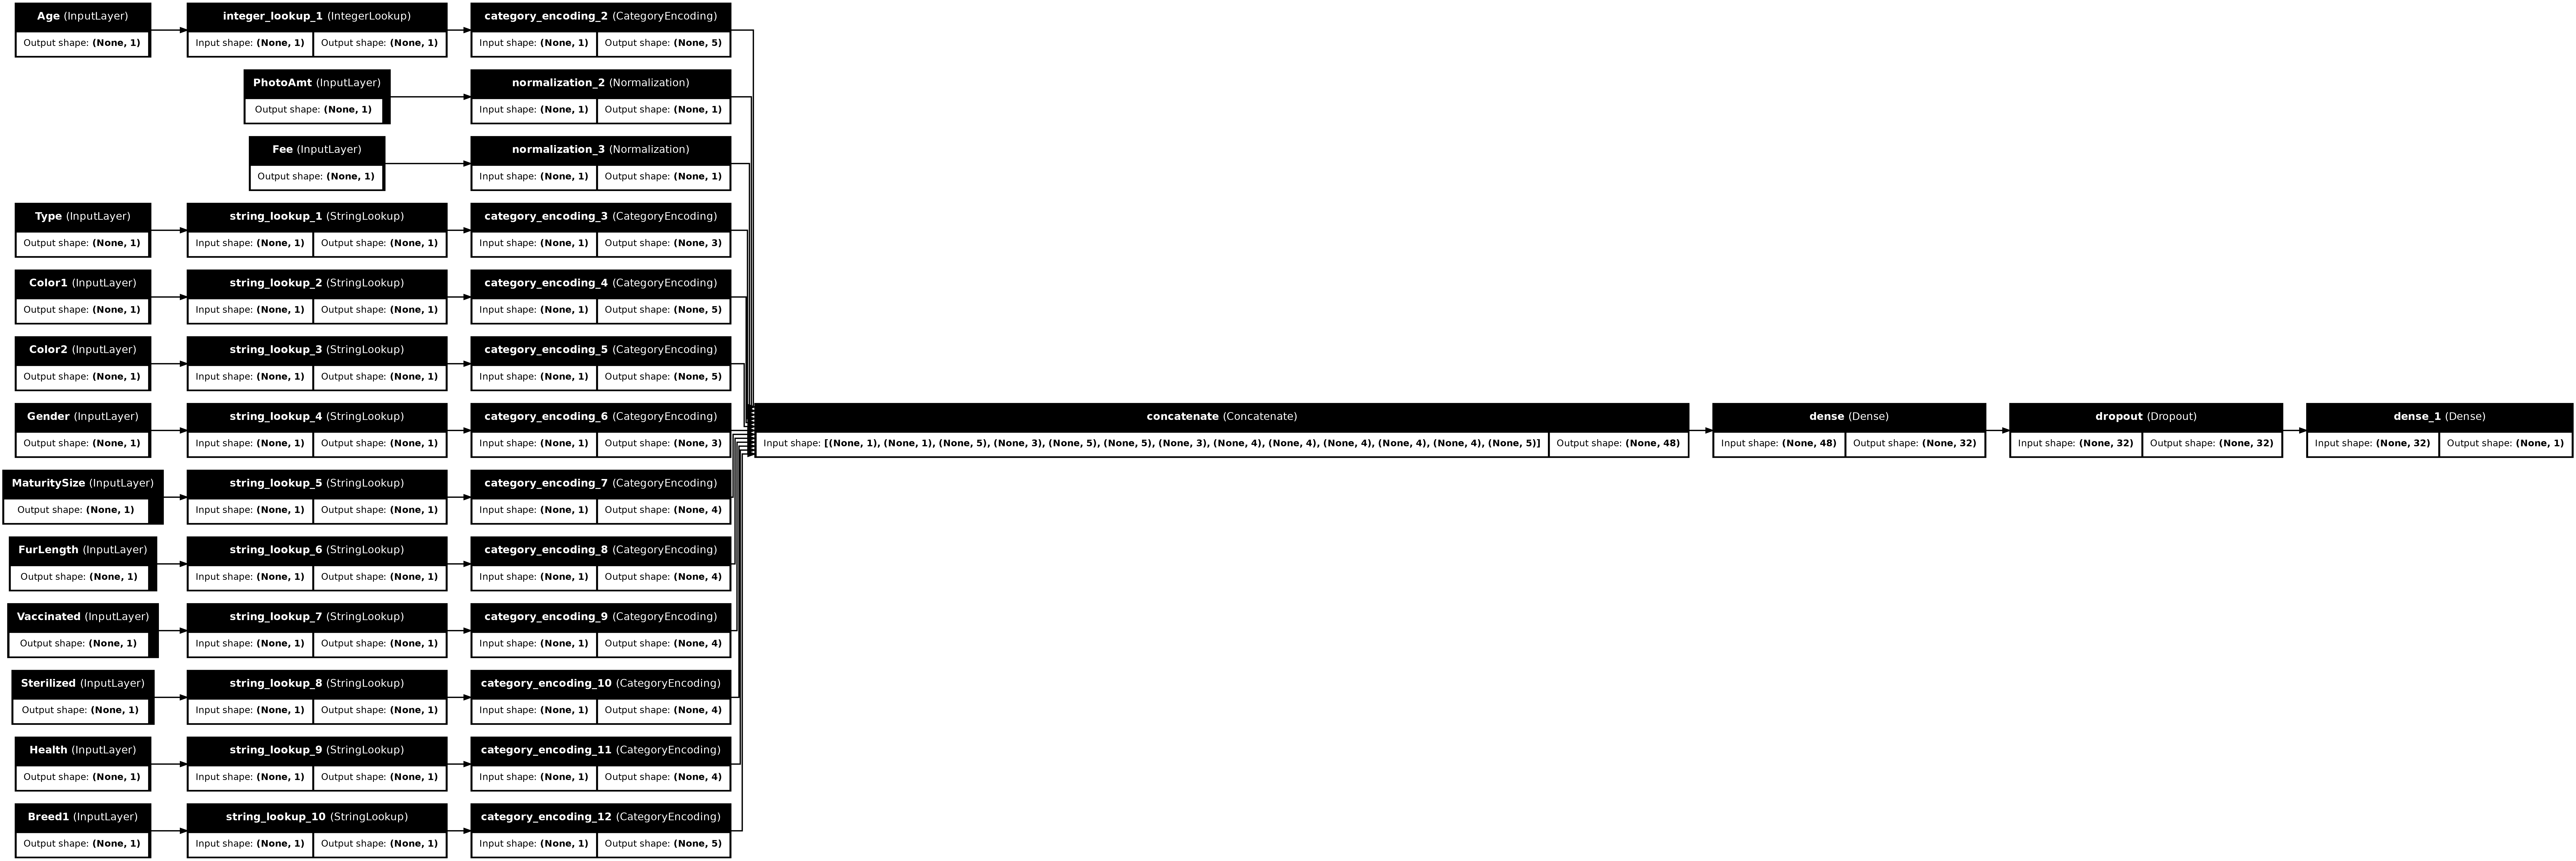

In [44]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, rankdir="LR")

In [45]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'PhotoAmt': 'PhotoAmt', 'Fee': 'Fee', 'Age': 'Age', 'Type': 'Type', 'Color1': 'Color1', 'Color2': 'Color2', 'Gender': 'Gender', 'MaturitySize': 'MaturitySize', 'FurLength': 'FurLength', 'Vaccinated': 'Vaccinated', 'Sterilized': 'Sterilized', 'Health': 'Health', 'Breed1': 'Breed1'}. Received: the structure of inputs={'Type': '*', 'Age': '*', 'Breed1': '*', 'Gender': '*', 'Color1': '*', 'Color2': '*', 'MaturitySize': '*', 'FurLength': '*', 'Vaccinated': '*', 'Sterilized': '*', 'Health': '*', 'Fee': '*', 'PhotoAmt': '*', 'target': '*'}
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.4341 - loss: 0.6787 - val_accuracy: 0.6200 - val_loss: 0.5829
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.5736 - loss: 0.6312 - val_accuracy: 0.7240 - val_loss: 0.5672
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.6293 - loss: 0.6091 - val_accuracy: 0.7200 - val_loss: 0.5629
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6457 - loss: 0.5897 - val_accuracy: 0.6980 - val_loss: 0.5599
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6729 - loss: 0.5678 - val_accuracy: 0.6980 - val_loss: 0.5571
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6706 - loss: 0.5673 - val_accuracy: 0.6800 - val_loss: 0.5555
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.6521 - loss: 0.5779 - val_accuracy: 0.6780 - val_loss: 0.5537
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.6949 - loss: 0.5599 - val_accuracy: 0.6820 - val_loss: 0.

In [ ]:
result = model.evaluate(test_ds, return_dict=True)
print(result)